In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Years to include
years = range(1990, 2025)  # 2025 is exclusive
                            # Could put years from 1968

# Base URL to the raw GitHub files
base_url = "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_{}.csv"

# Create empty list to store all DataFrames
dfs = []

# Loop through each year, read the CSV, and append to list
for year in years:
    url = base_url.format(year)
    try:
        df = pd.read_csv(url)
        df['year'] = year  # Add year column for later filtering
        dfs.append(df)
    except Exception as e:
        print(f"Could not load {year}: {e}")

# Combine all years into one big DataFrame
all_matches = pd.concat(dfs, ignore_index=True)
print("All match data loaded!")


All match data loaded!


In [8]:
# Filter Grand Slams, Masters 1000, ATP Finals, Olympics
major_matches = all_matches[
    (all_matches['tourney_level'].isin(['G', 'M', 'F'])) |
    (all_matches['tourney_name'].str.contains("Olympics", na=False))
]


Assigns a GOAT rank per year, using these chosen tie-breakers:
1. Most titles
2. Most aces
3. Highest 1st serve win %
Ranks players within each year
Shows the top players per year, even if titles are tied

In [ ]:
# Step 1: Filter Grand Slam finals
slam_finals = major_matches[
    (major_matches['tourney_level'] == 'G') &
    (major_matches['round'] == 'F')
].copy()

# Step 2: Count titles per player per year
goat_slam_winners = slam_finals.groupby(['year', 'winner_name']).size().reset_index(name='titles')

# Step 3A: Total aces
aces = slam_finals.groupby(['year', 'winner_name'])['w_ace'].sum().reset_index(name='total_aces')

# Step 3B: 1st serve win %
slam_finals['1st_win_pct'] = slam_finals['w_1stWon'] / slam_finals['w_1stIn']
first_serve_pct = slam_finals.groupby(['year', 'winner_name'])['1st_win_pct'].mean().reset_index()

# Step 4: Merge all stats
goat_data = goat_slam_winners.merge(aces, on=['year', 'winner_name'], how='left')
goat_data = goat_data.merge(first_serve_pct, on=['year', 'winner_name'], how='left')

# Step 5: Clean missing values
goat_data['total_aces'] = goat_data['total_aces'].replace({np.nan: 0})
goat_data['1st_win_pct'] = goat_data['1st_win_pct'].replace({np.nan: 0})

# Step 6: Remove players with zero in BOTH tie-breaker metrics
goat_data = goat_data[~((goat_data['total_aces'] == 0) & (goat_data['1st_win_pct'] == 0))]

# Step 7: Sort by GOAT logic (with fallbacks)
goat_data = goat_data.sort_values(
    by=['year', 'titles', 'total_aces', '1st_win_pct'],
    ascending=[True, False, False, False]
)

# Step 8: Rank players per year
goat_data['GOAT_rank'] = goat_data.groupby('year').cumcount() + 1

# ✅ Final ranked list
print(goat_data)


     year     winner_name  titles  total_aces  1st_win_pct  GOAT_rank
6    1991   Michael Stich       1        15.0     0.760870          1
4    1991    Boris Becker       1         9.0     0.697674          2
5    1991     Jim Courier       1         9.0     0.647727          3
7    1991   Stefan Edberg       1         2.0     0.825000          4
9    1992     Jim Courier       2         9.0     0.702120          1
..    ...             ...     ...         ...          ...        ...
97   2022  Carlos Alcaraz       1        14.0     0.741176          3
101  2023  Novak Djokovic       3        22.0     0.809679          1
100  2023  Carlos Alcaraz       1         9.0     0.702128          2
103  2024   Jannik Sinner       2        20.0     0.811179          1
102  2024  Carlos Alcaraz       2         8.0     0.742560          2

[98 rows x 6 columns]


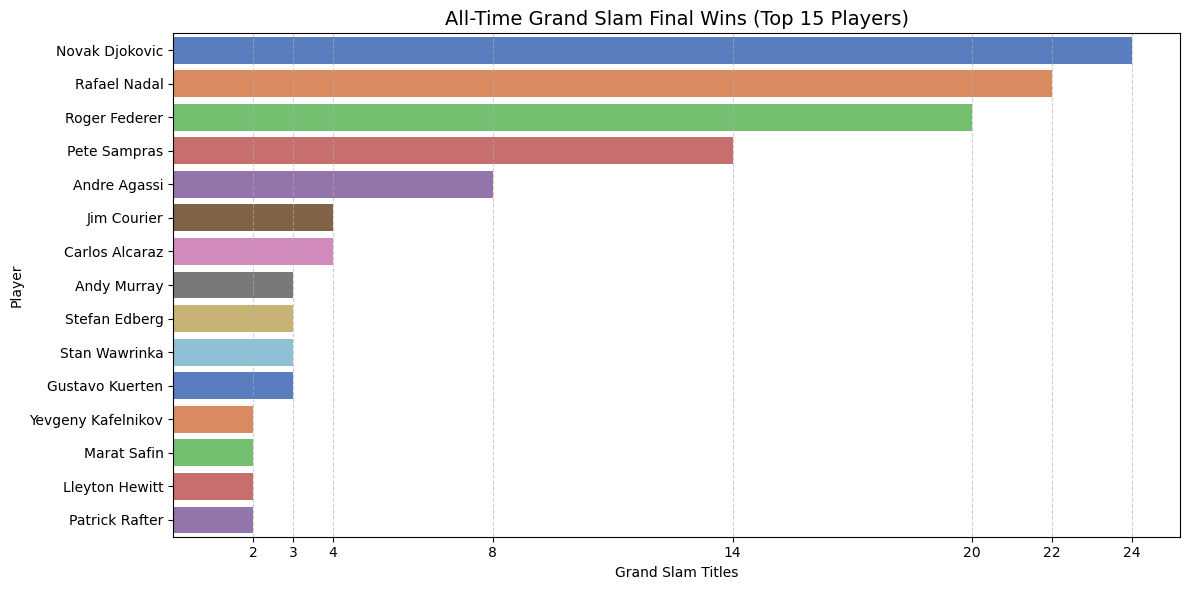

In [29]:
# All-time Grand Slam final wins
all_time_goats = slam_finals.groupby('winner_name').size().reset_index(name='total_titles')
all_time_goats = all_time_goats.sort_values(by='total_titles', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=all_time_goats,
    x='total_titles',
    y='winner_name',
    hue='winner_name',
    palette='muted',
    dodge=False,
    legend=False
)

plt.title("All-Time Grand Slam Final Wins (Top 15 Players)", fontsize=14)
plt.xlabel("Grand Slam Titles")
plt.ylabel("Player")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Set x-axis ticks to every individual title value
plt.xticks(ticks=sorted(all_time_goats['total_titles'].unique()))

plt.tight_layout()
plt.show()


Skipping 1990 — no valid stats for tie-breaker comparison.


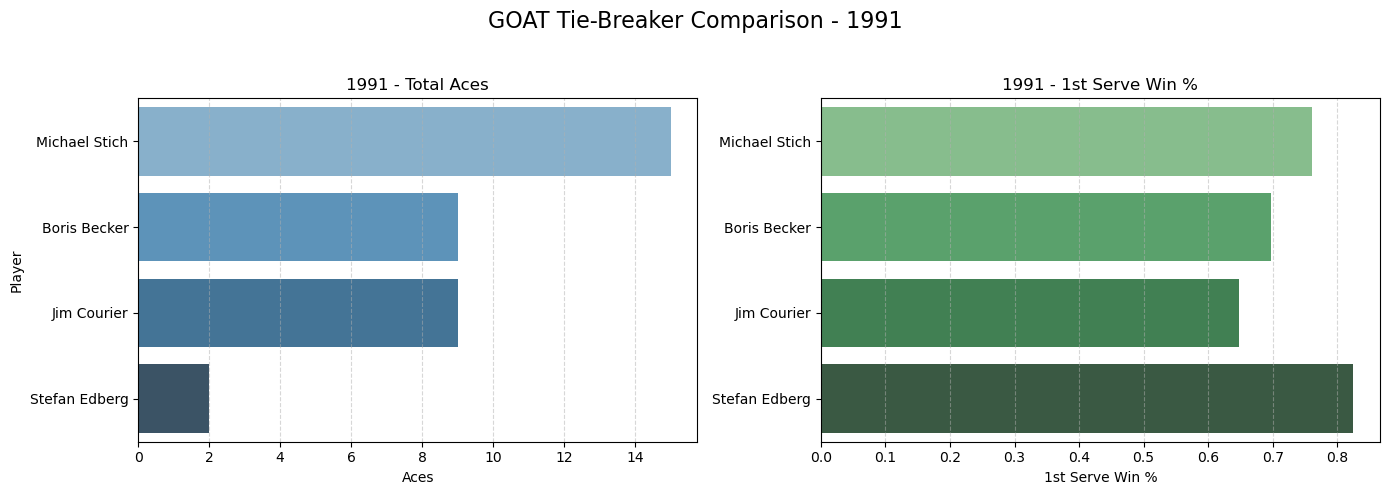

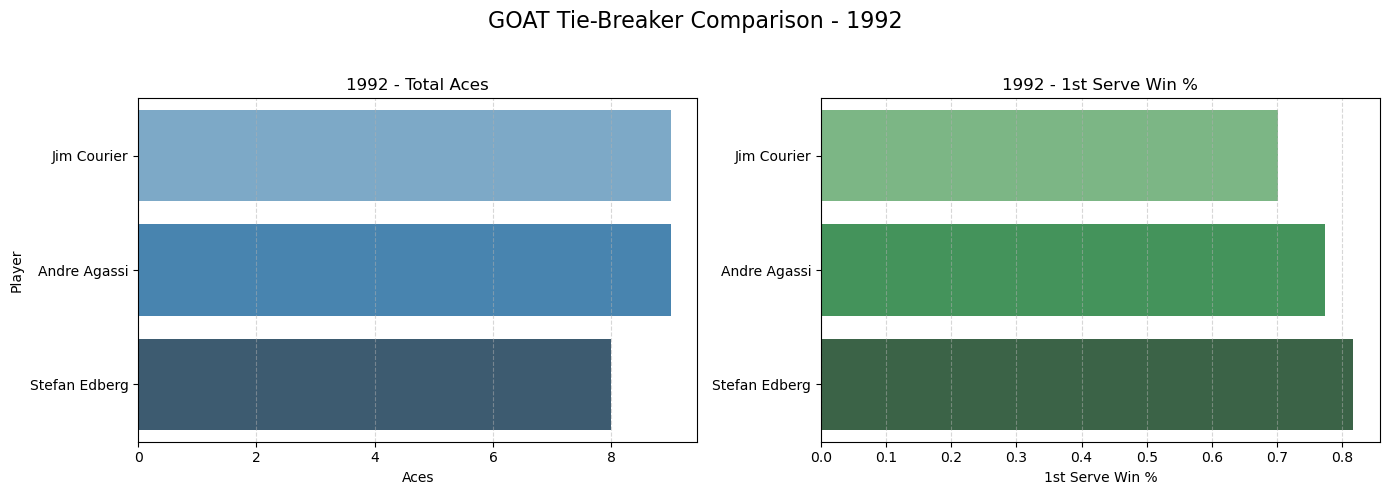

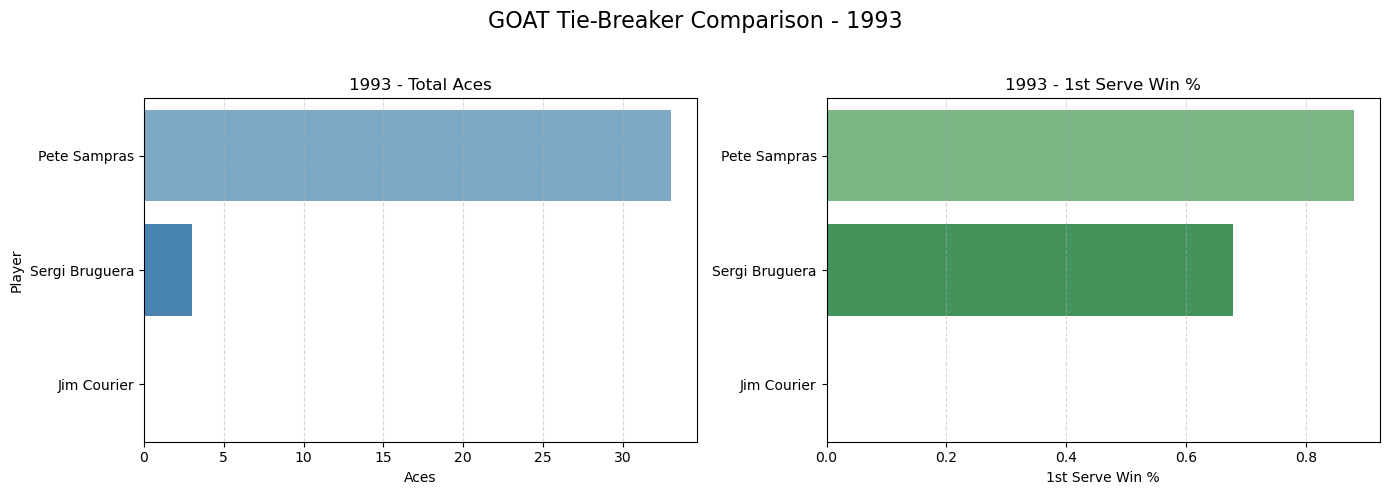

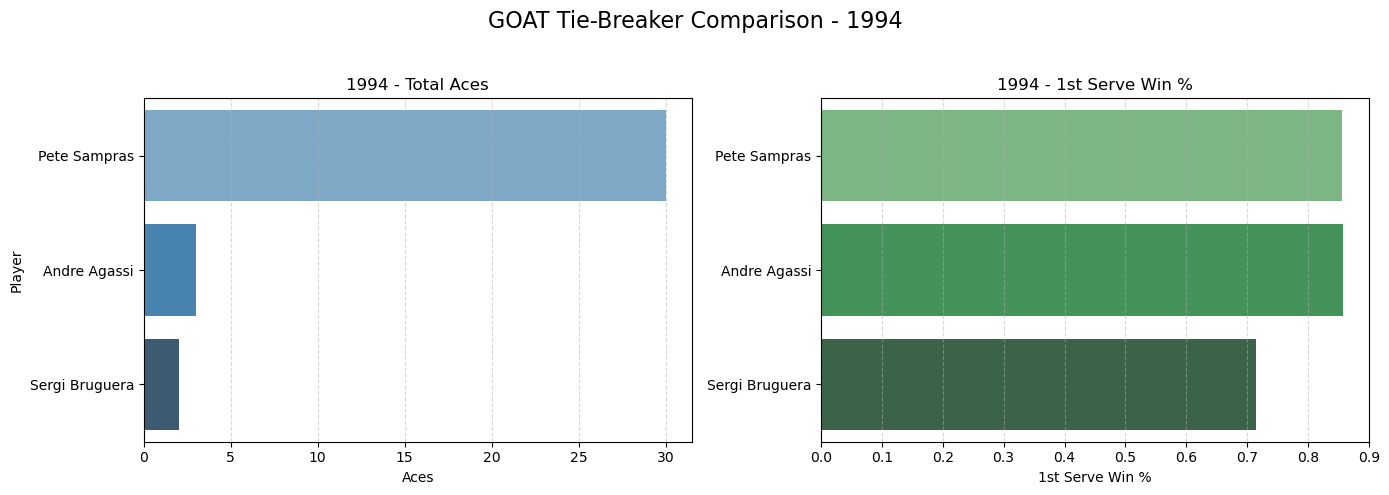

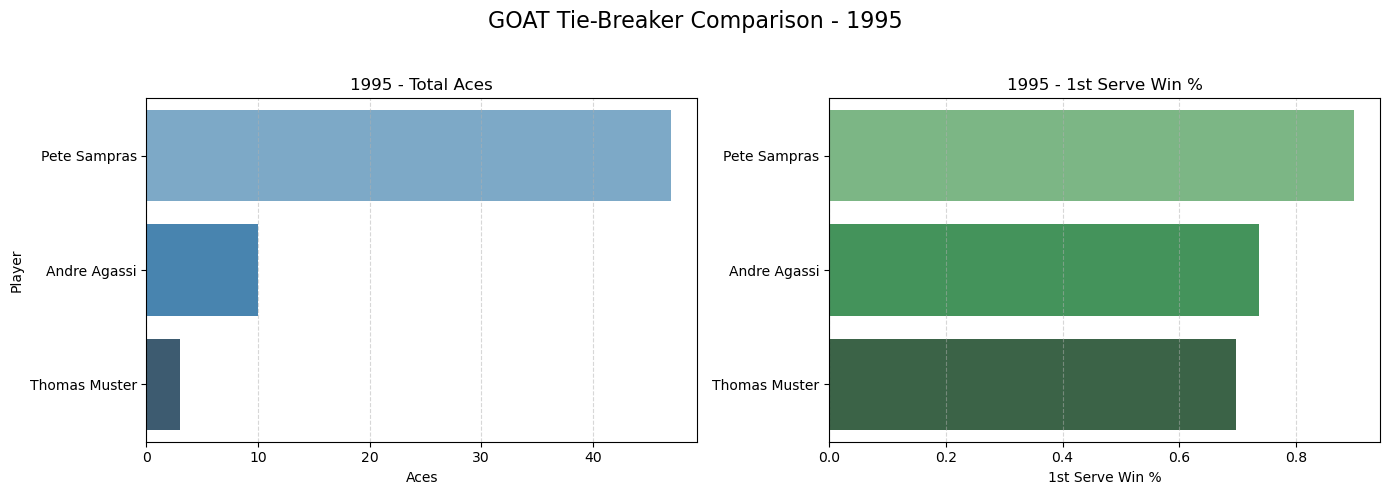

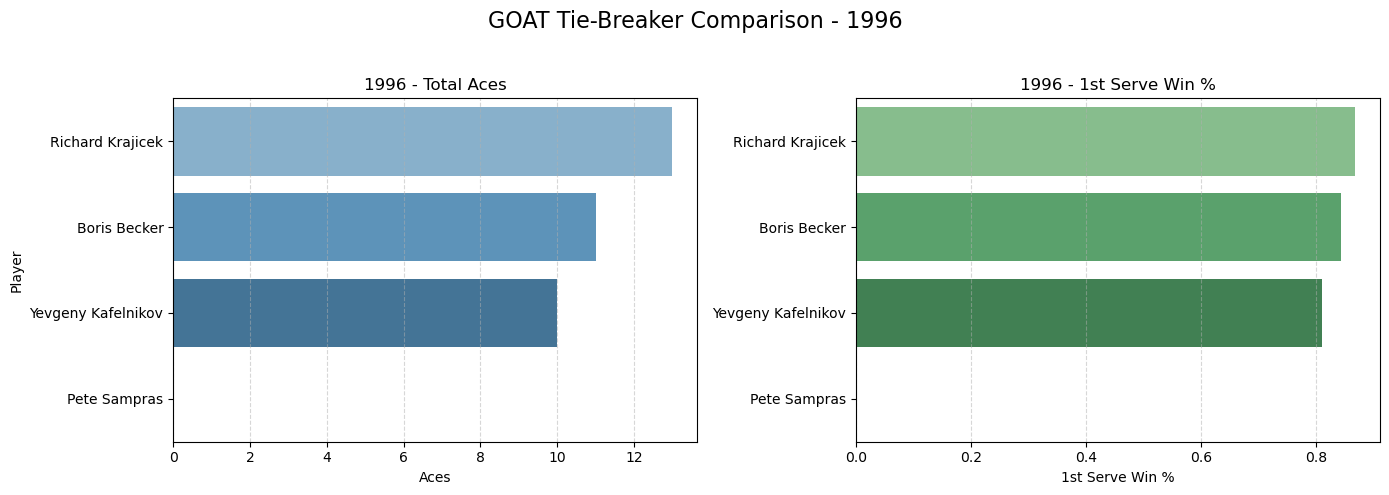

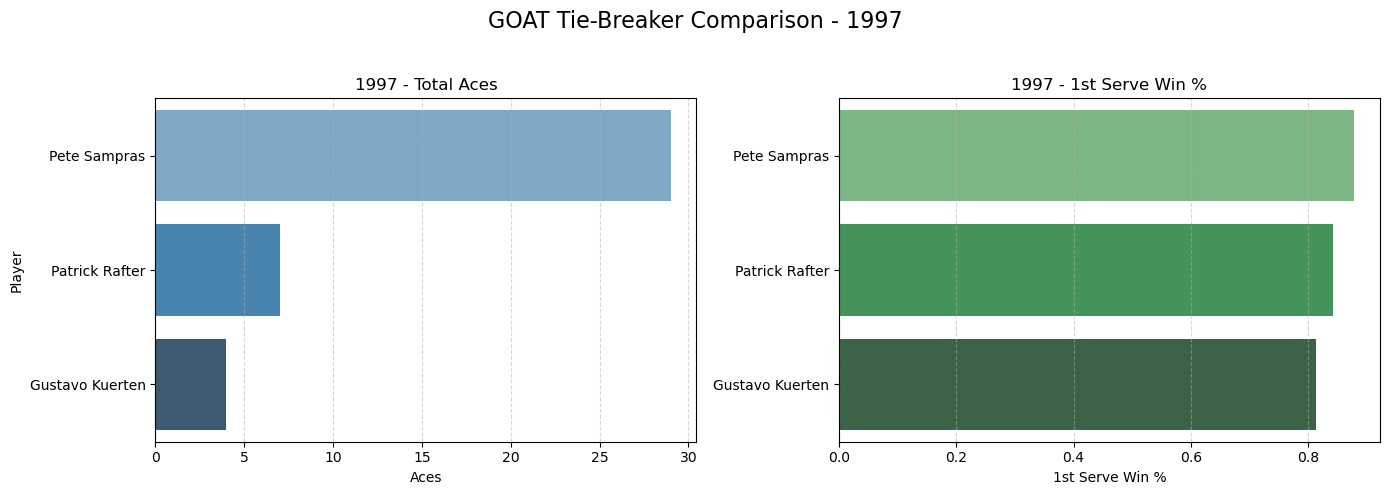

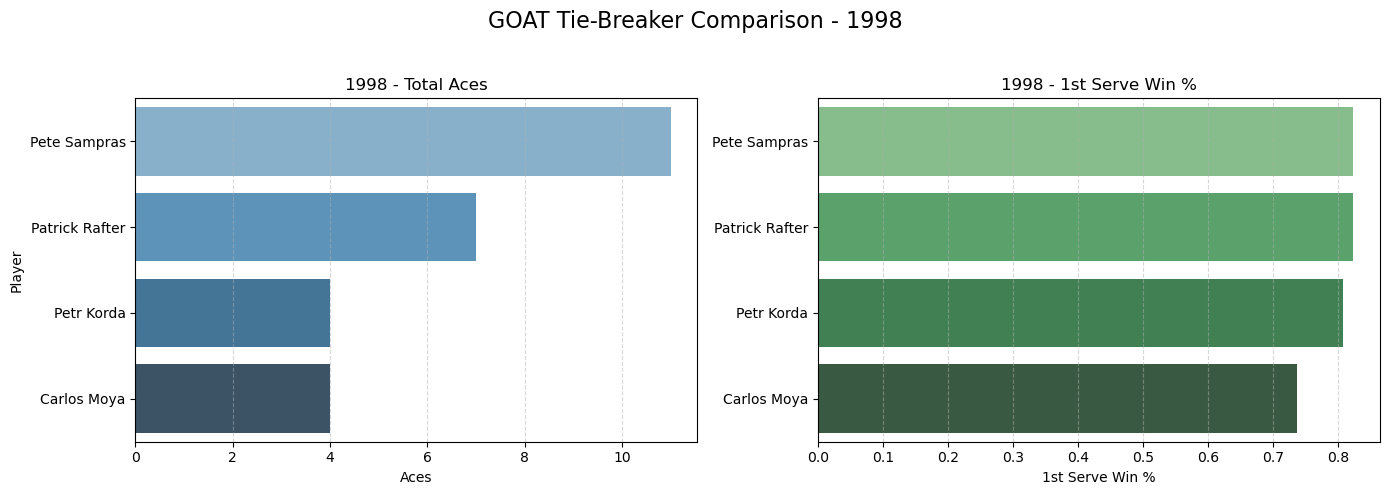

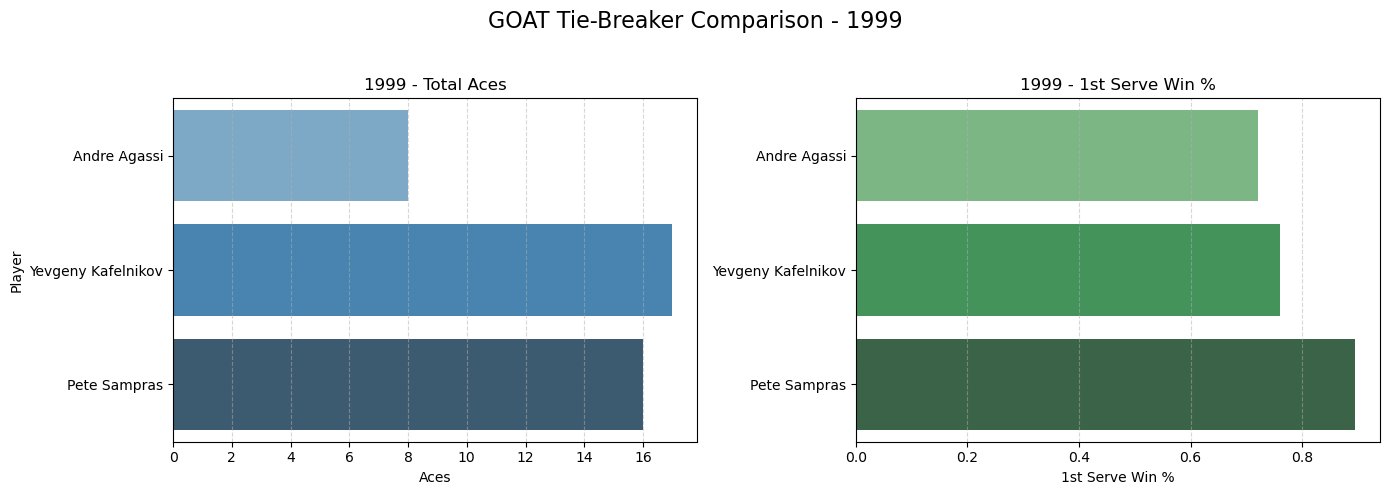

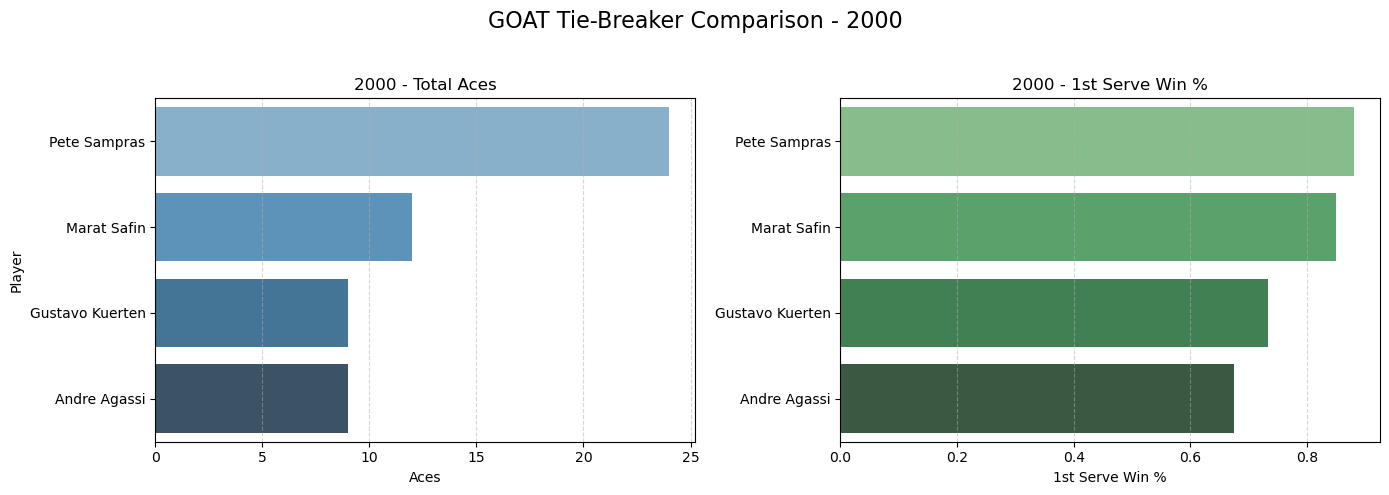

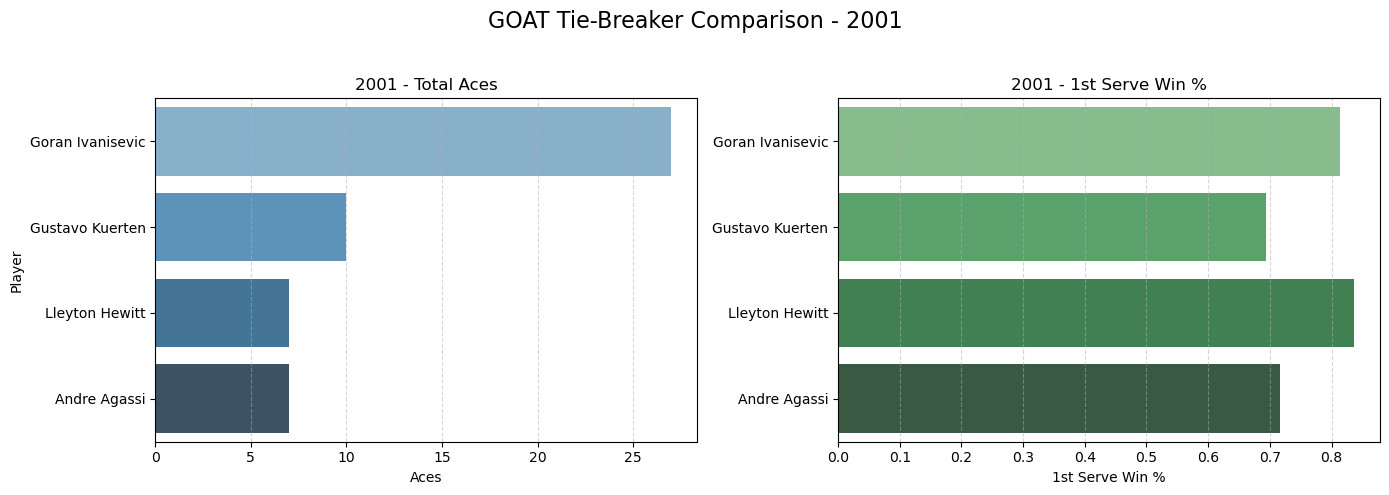

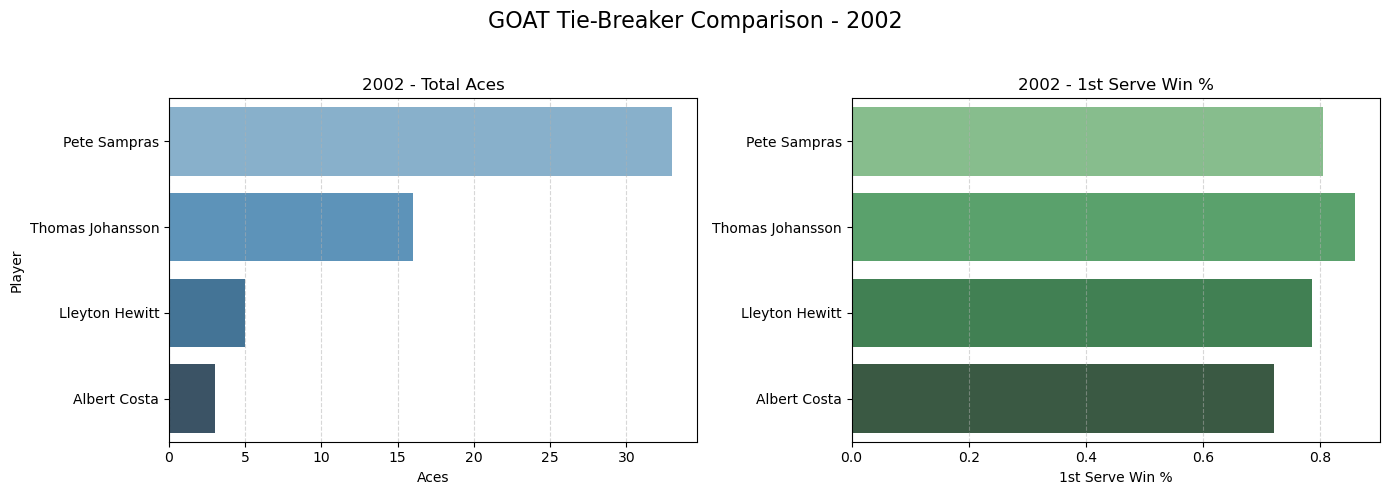

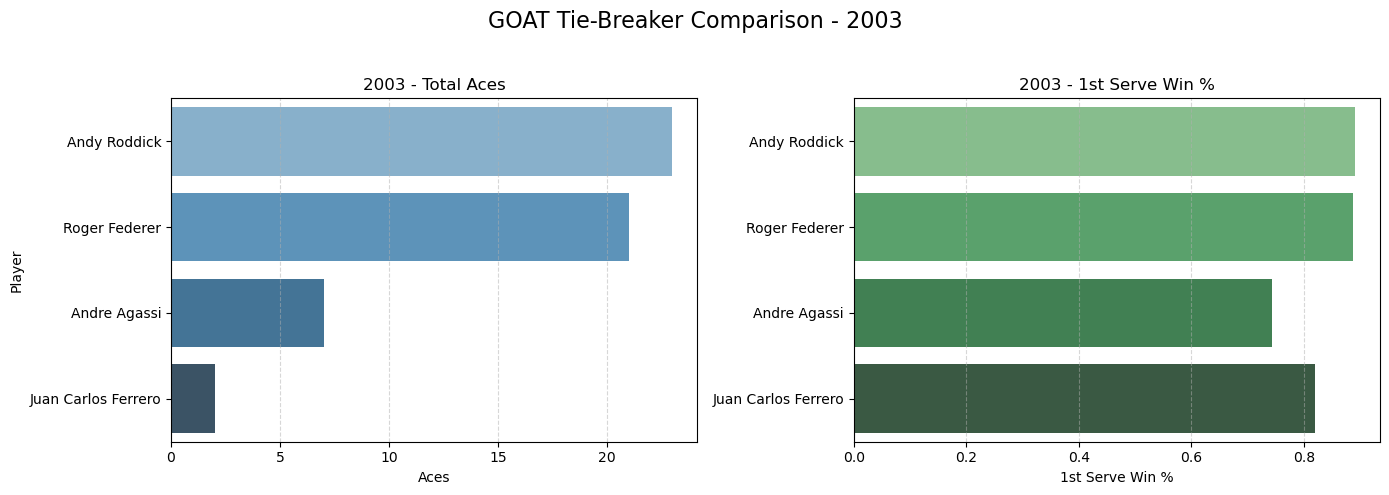

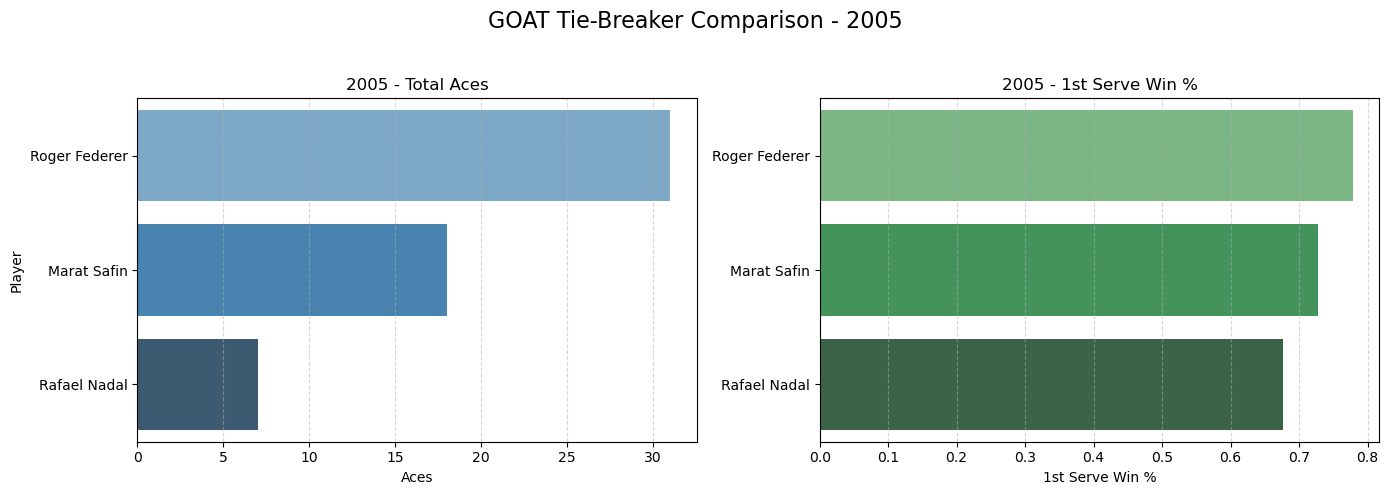

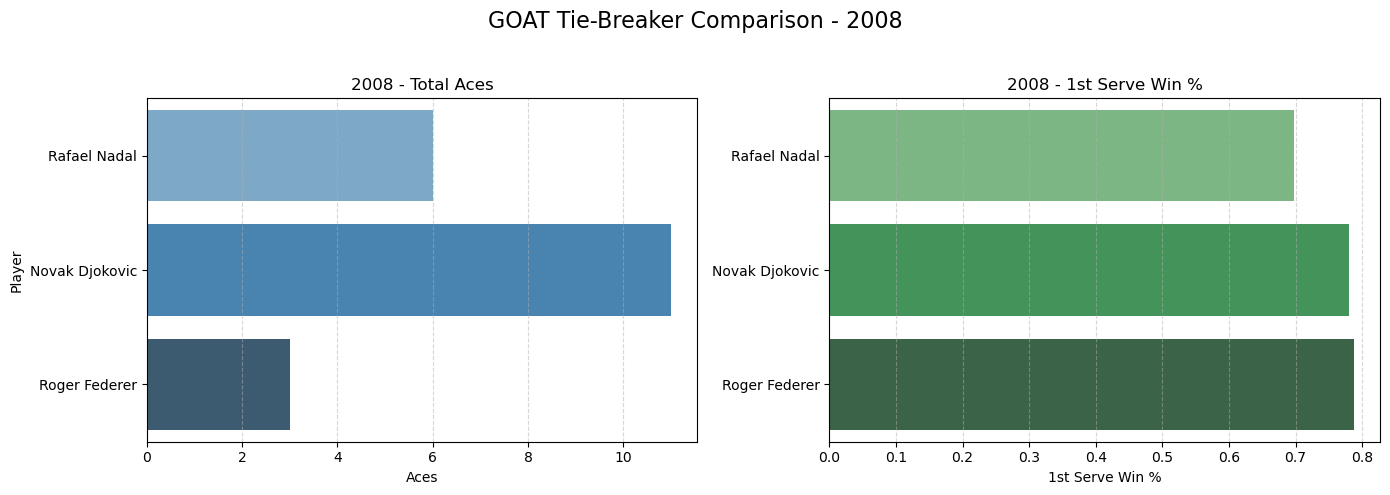

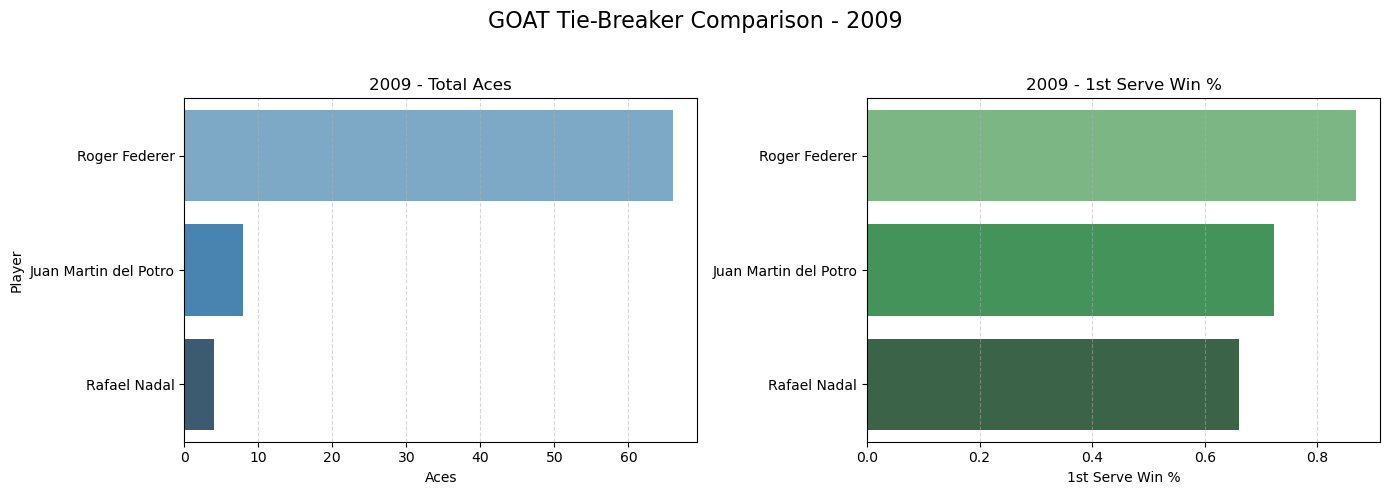

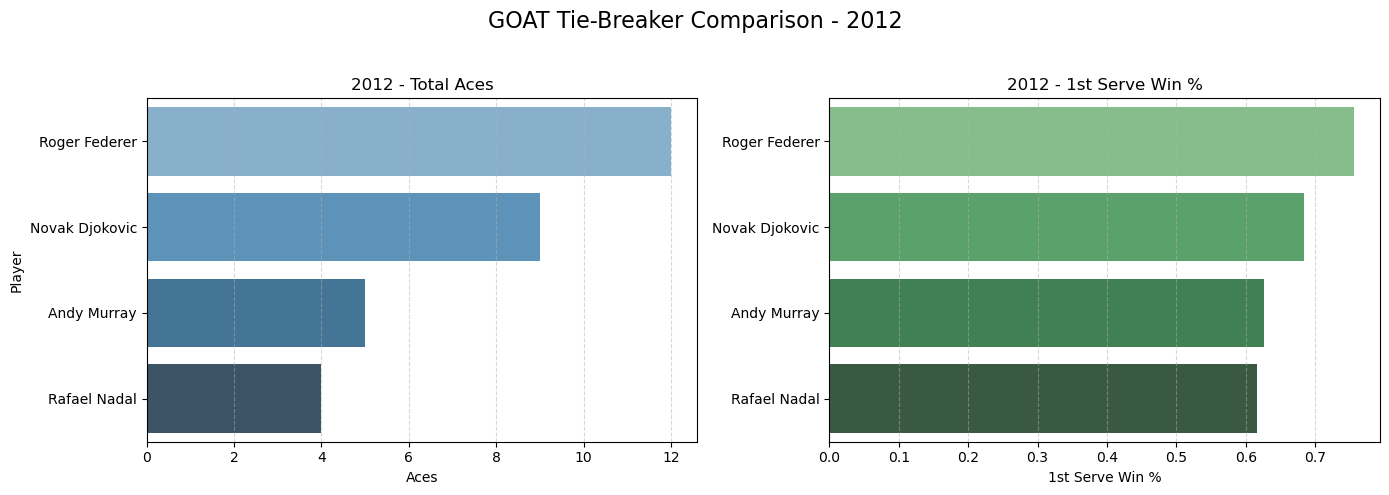

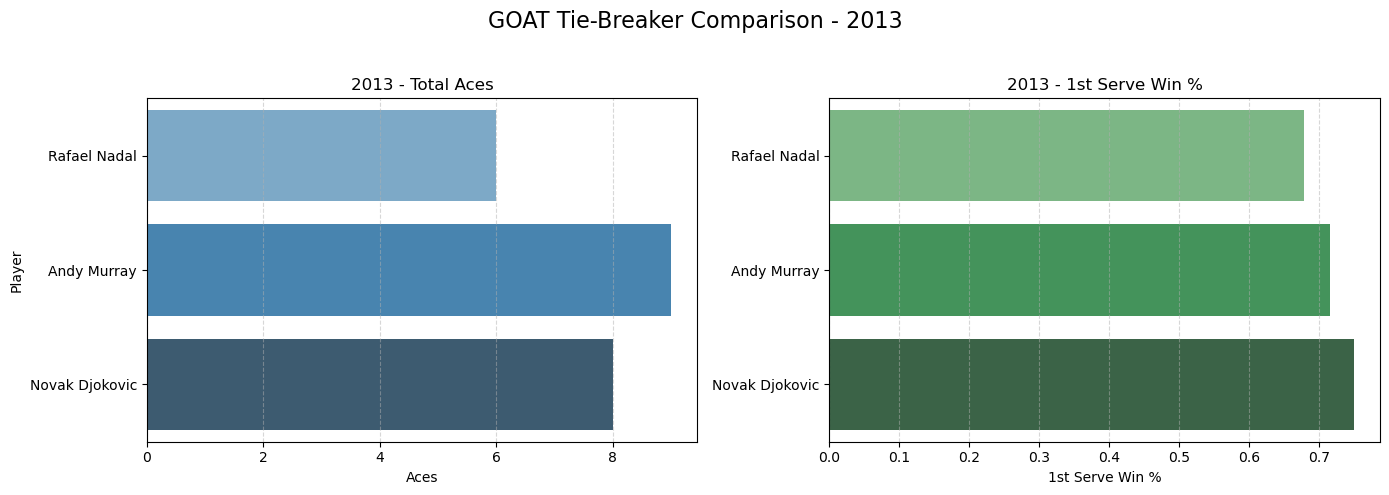

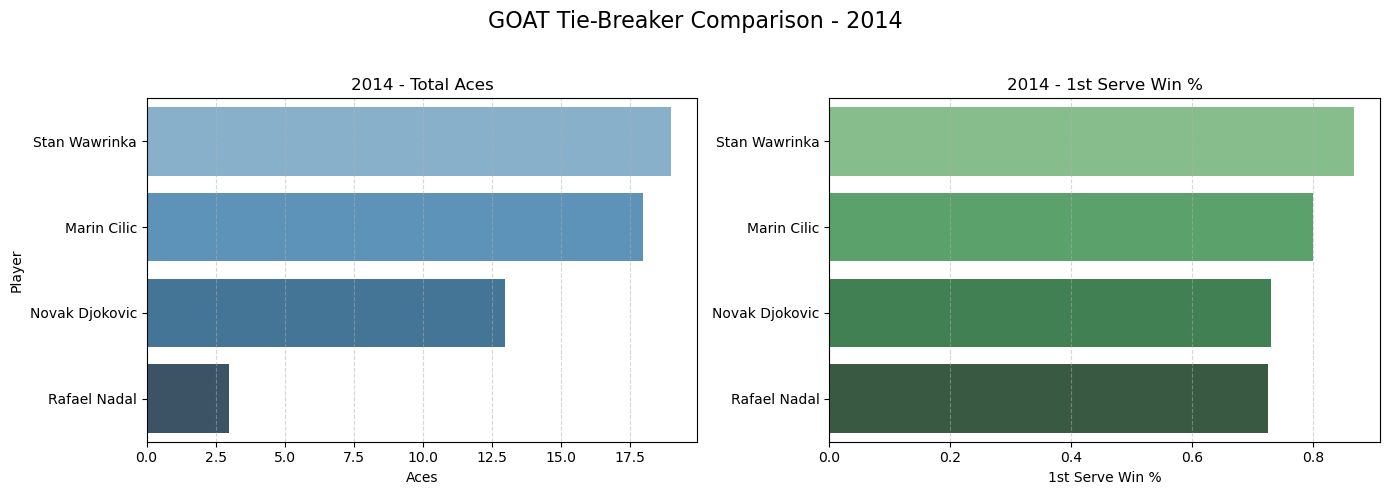

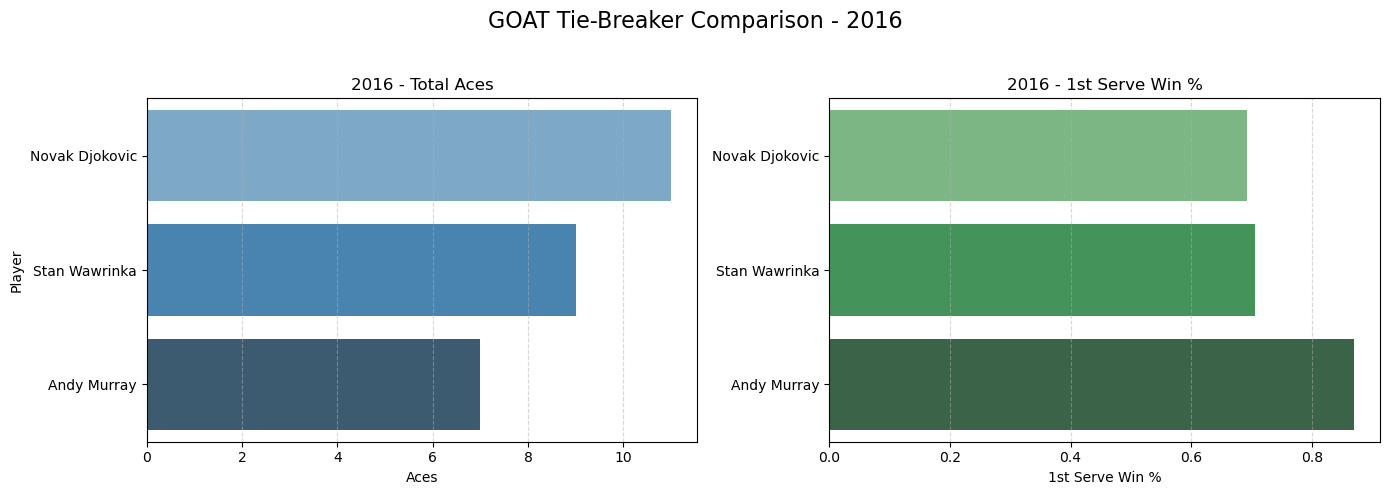

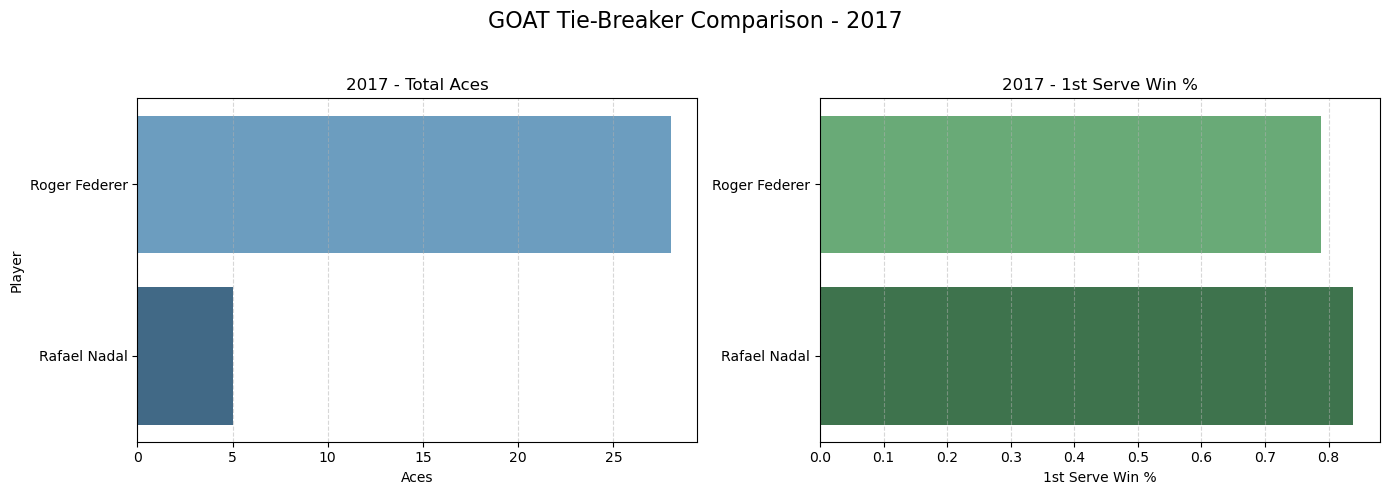

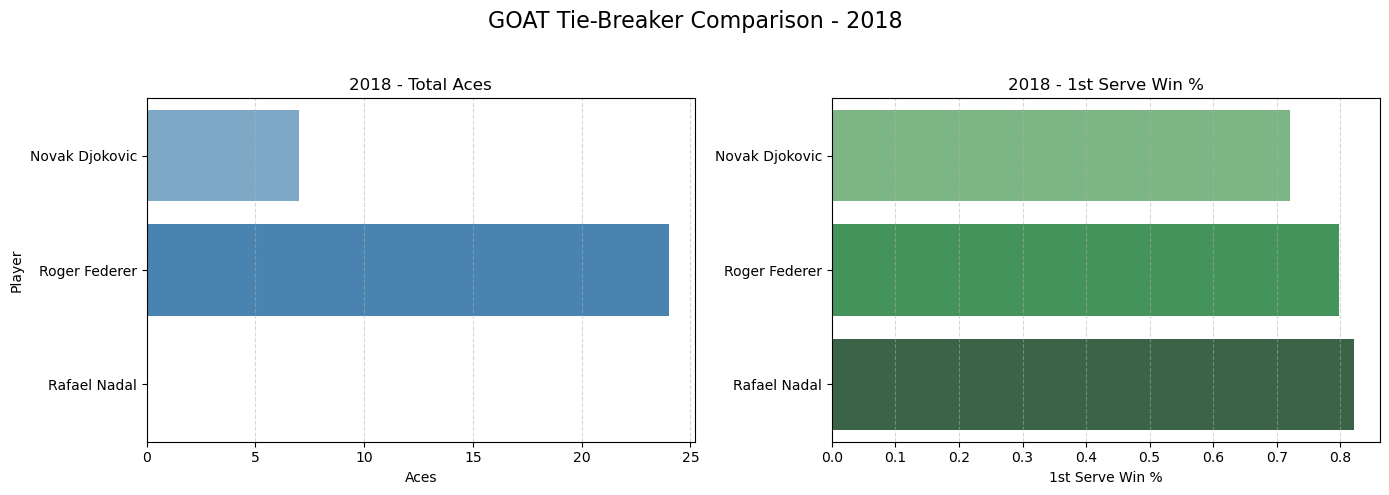

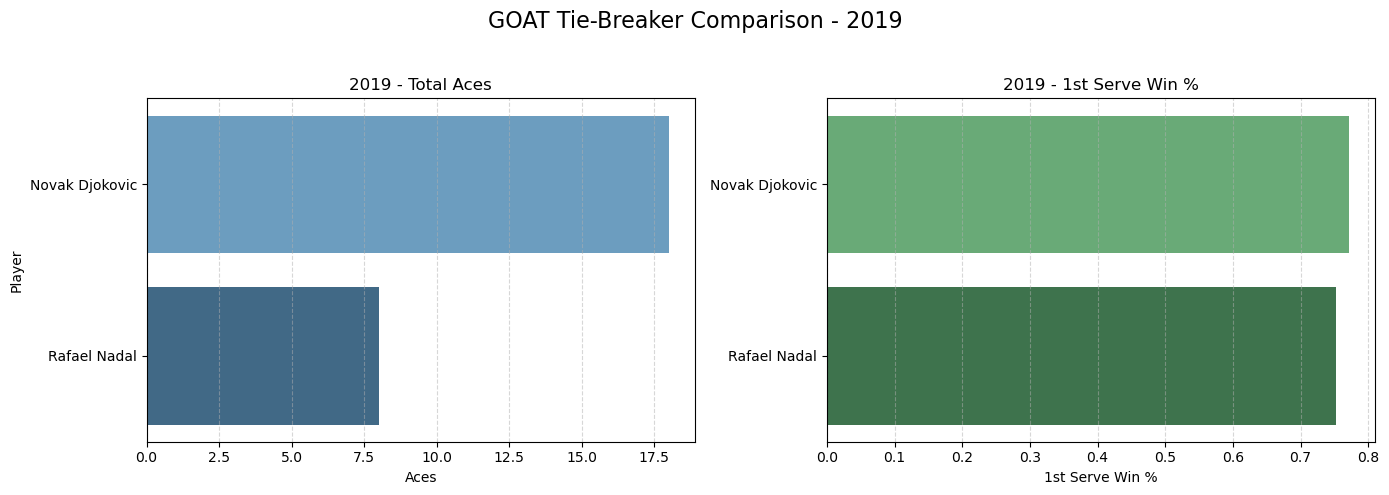

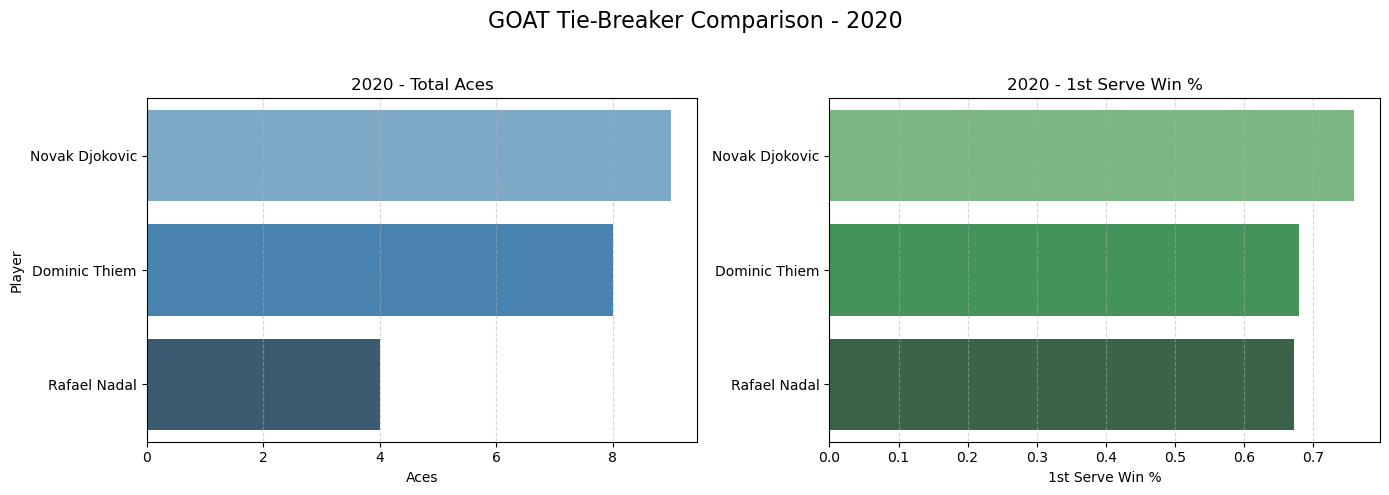

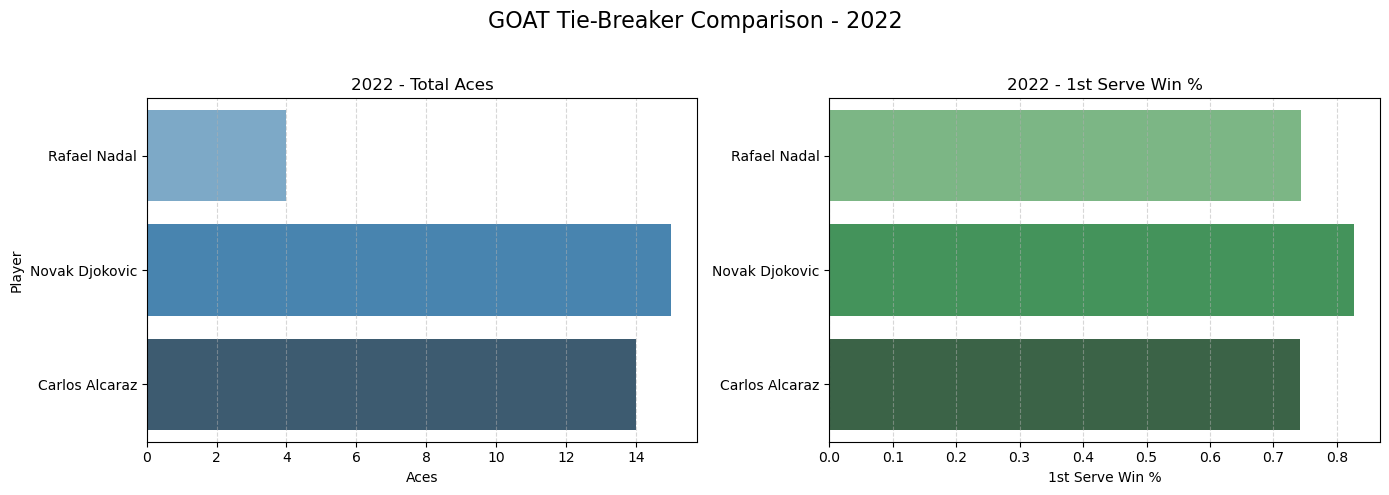

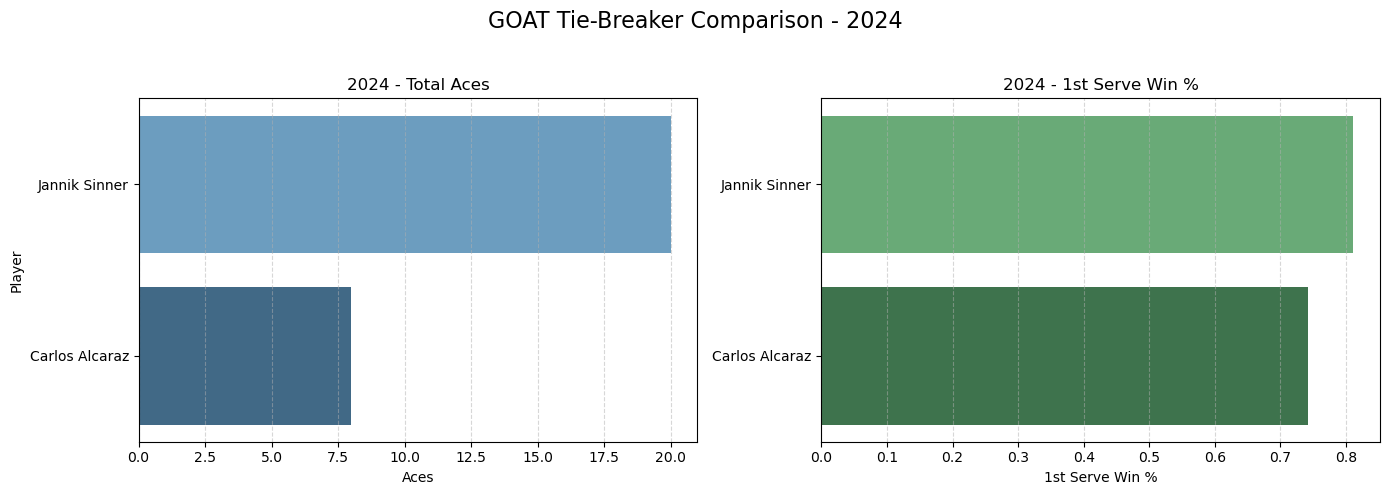

In [25]:
# Per-Year Tie Comparison Plots (Only Years with Ties)

# Step 1: Find years with ties in number of titles
tied_years = (
    goat_data.groupby(['year'])['titles']
    .value_counts()
    .reset_index(name='count')
    .query('count > 1')  # Only where more than 1 player had the same title count
)

# Get the years where there's a tie
years_with_ties = tied_years['year'].unique()

# Step 2: Filter only tied years from goat_data
tied_goat_data = goat_data[goat_data['year'].isin(years_with_ties)]

# Step 3: Create separate plots for each tied year
for year in sorted(years_with_ties):
    data = tied_goat_data[tied_goat_data['year'] == year].copy()

    # Skip year if all values are NaN or 0 for both tie-breakers
    if data[['total_aces', '1st_win_pct']].isna().all().all() or (
        data['total_aces'].fillna(0).sum() == 0 and data['1st_win_pct'].fillna(0).sum() == 0
    ):
        print(f"Skipping {year} — no valid stats for tie-breaker comparison.")
        continue

    # Replace NaNs with 0s to avoid empty bars
    data['total_aces'] = data['total_aces'].fillna(0)
    data['1st_win_pct'] = data['1st_win_pct'].fillna(0)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot total aces
    sns.barplot(data=data, x='total_aces', y='winner_name', hue='winner_name',
                palette='Blues_d', ax=ax[0], dodge=False, legend=False)
    ax[0].set_title(f'{year} - Total Aces')
    ax[0].set_xlabel('Aces')
    ax[0].set_ylabel('Player')
    ax[0].grid(axis='x', linestyle='--', alpha=0.5)

    # Plot 1st serve win %
    sns.barplot(data=data, x='1st_win_pct', y='winner_name', hue='winner_name',
                palette='Greens_d', ax=ax[1], dodge=False, legend=False)
    ax[1].set_title(f'{year} - 1st Serve Win %')
    ax[1].set_xlabel('1st Serve Win %')
    ax[1].set_ylabel('')
    ax[1].grid(axis='x', linestyle='--', alpha=0.5)

    fig.suptitle(f"GOAT Tie-Breaker Comparison - {year}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

